
## Классификация изображений из датасета [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html)


## Часть 1

Требования

1. Используйте фреймворк [Pytorch](https://pytorch.org/)

2. Не используйте предобученные модели.

3. Можете загрузить готовую модель или использовать собственную архитектуру.

4. Выберите способ оценки качества предсказаний модели. Обоснуйте его.

5. Проведите обучение. Продемонстрируйте умение использовать соответствующие инструменты.

6. Оцените полученный результат.

*Не используйте инструменты принцип работы которых вам непонятен.

### Данные

In [1]:
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import random
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [3]:
batch_size = 50 # кратный всем выборкам, чтобы не осталось не полных батчей

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

train_val_dataset = datasets.CIFAR10(root='./data', train=True, download=True)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform = val_transform)

# Вернуть данные на финальное обучение
train_dataset, val_dataset = torch.utils.data.random_split(train_val_dataset, [40000, 10000])

train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = val_transform

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


class_names = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


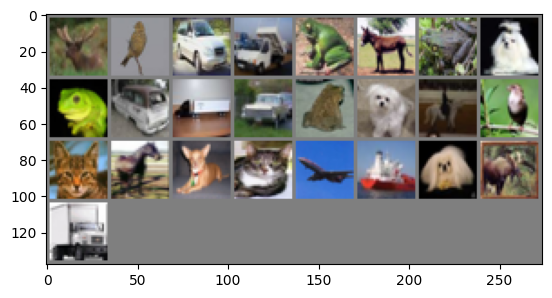

deer  bird  car   truck frog  horse frog  dog   frog  car   truck car   frog  dog   horse bird  cat   horse dog   cat   plane ship  dog   deer  truck


In [4]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(train_dataloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{class_names[labels[j]]:5s}' for j in range(batch_size)))

#### Сбаласированность классов

In [4]:
def check_class_balance(dataloader):
    classes = []
    for batch_idx, data in enumerate(dataloader, 0):
        x, y = data
        classes.extend(y.tolist())

    #Calculating the unique classes and the respective counts and plotting them
    unique, counts = np.unique(classes, return_counts=True)
    plt.bar(class_names, counts)
    plt.xlabel("Target Classes")
    plt.ylabel("Number of training instances")

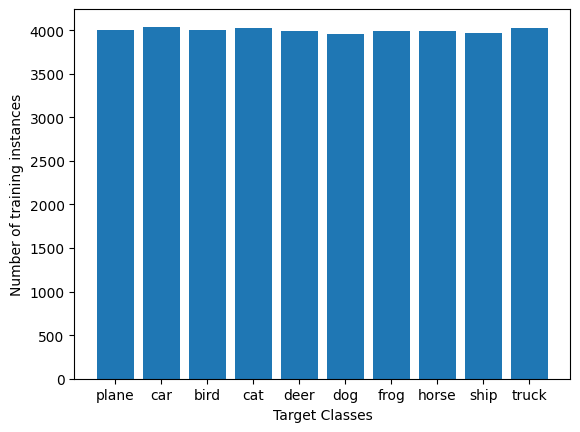

In [5]:
check_class_balance(train_dataloader)

Классы имеют незначительный дисбаланс

#### Метрики

Варианты метрик качества:  
Взвешанные Accuracy, Precision, Recall, F1  
Классы сбалансированы, поэтому можно взять **Accuracy**

### Модель

In [7]:
!mkdir ./check_points
!mkdir ./check_points/task_1

In [6]:
def save_model(model, model_path):
    torch.save(model.state_dict(), f"{model_path}{type(model).__name__}.pth")

In [7]:
def train_model(model, loss, optimizer, scheduler, num_epochs, checkpoints_folder):
    loss_history = {'train': [], 'val': []}
    accuracy_history = {'train': [], 'val': []}

    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                dataloader = val_dataloader
                model.eval()   # Set model to evaluate mode

            running_loss = 0.
            running_acc = 0.

            # Iterate over data.
            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # forward and backward
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()

                # statistics
                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean()


            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)

            loss_history[phase].append(float(epoch_loss))
            accuracy_history[phase].append(float(epoch_acc.cpu()))

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)
            save_model(model, f'./check_points/{checkpoints_folder}/epoch_{epoch}_')

    for phase in ['train', 'val']:
        plt.plot(accuracy_history[phase], label=phase)
    plt.legend()
    plt.title('Accuracy')
    plt.show()
    min_acc = max(accuracy_history['val'])
    print(f"Best Val Accuracy:{min_acc} epoch {accuracy_history['val'].index (min_acc)}")

    for phase in ['train', 'val']:
        plt.plot(loss_history[phase], label=phase)
    plt.legend()
    plt.title('Loss')
    plt.show()
    min_loss = min(loss_history['val'])
    print(f"Best Val Loss:{min_loss} epoch {loss_history['val'].index (min_loss)}")


    return model

### Обучение

In [8]:
from torchvision.models import resnet50
resnet_50 = resnet50()

# Нам нужен на выходе ответ в виде 10 чисел
resnet_50.fc = torch.nn.Linear(resnet_50.fc.in_features, 10)

resnet_50 = resnet_50.to(device)

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet_50.parameters(), lr=1.0e-3)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [9]:
train_model(resnet_50, loss, optimizer, scheduler, num_epochs=25, checkpoints_folder='task_1')

Epoch 0/24:


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
  0%|          | 0/800 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
100%|██████████| 800/800 [00:45<00:00, 17.39it/s]

train Loss: 1.9264 Acc: 0.3712



100%|██████████| 200/200 [00:04<00:00, 42.91it/s]

val Loss: 2.4868 Acc: 0.4058


Epoch 1/24:


100%|██████████| 800/800 [00:45<00:00, 17.69it/s]

train Loss: 1.7547 Acc: 0.4149



100%|██████████| 200/200 [00:04<00:00, 41.65it/s]

val Loss: 1.5632 Acc: 0.4678


Epoch 2/24:


100%|██████████| 800/800 [00:44<00:00, 17.84it/s]

train Loss: 1.5761 Acc: 0.4648



100%|██████████| 200/200 [00:04<00:00, 42.64it/s]

val Loss: 1.8161 Acc: 0.4713


Epoch 3/24:


100%|██████████| 800/800 [00:44<00:00, 18.04it/s]

train Loss: 1.4896 Acc: 0.4976



100%|██████████| 200/200 [00:04<00:00, 41.77it/s]

val Loss: 2.4405 Acc: 0.5302


Epoch 4/24:


100%|██████████| 800/800 [00:44<00:00, 18.06it/s]

train Loss: 1.1881 Acc: 0.5769



100%|██████████| 200/200 [00:04<00:00, 41.87it/s]

val Loss: 1.3600 Acc: 0.5920


Epoch 5/24:


100%|██████████| 800/800 [00:44<00:00, 17.92it/s]

train Loss: 1.0929 Acc: 0.6115



100%|██████████| 200/200 [00:04<00:00, 43.16it/s]

val Loss: 1.3624 Acc: 0.6123


Epoch 6/24:


100%|██████████| 800/800 [00:44<00:00, 18.18it/s]

train Loss: 1.0101 Acc: 0.6414



100%|██████████| 200/200 [00:04<00:00, 41.92it/s]

val Loss: 1.1230 Acc: 0.6276


Epoch 7/24:


100%|██████████| 800/800 [00:44<00:00, 17.83it/s]

train Loss: 0.9128 Acc: 0.6771



100%|██████████| 200/200 [00:04<00:00, 42.29it/s]

val Loss: 1.0949 Acc: 0.6440


Epoch 8/24:


100%|██████████| 800/800 [00:44<00:00, 17.95it/s]

train Loss: 0.8145 Acc: 0.7157



100%|██████████| 200/200 [00:04<00:00, 42.12it/s]

val Loss: 1.6679 Acc: 0.6497


Epoch 9/24:


100%|██████████| 800/800 [00:44<00:00, 17.79it/s]

train Loss: 0.6298 Acc: 0.7806



100%|██████████| 200/200 [00:06<00:00, 32.10it/s]

val Loss: 1.0730 Acc: 0.6604


Epoch 10/24:


100%|██████████| 800/800 [00:48<00:00, 16.52it/s]

train Loss: 0.5838 Acc: 0.7978



100%|██████████| 200/200 [00:05<00:00, 35.69it/s]

val Loss: 1.1074 Acc: 0.6599


Epoch 11/24:


 10%|▉         | 77/800 [00:04<00:39, 18.42it/s]


KeyboardInterrupt: 

### Оценка результата

In [12]:
def download_model(model_class, path):
    model = model_class.load_state_dict(torch.load(f"{path}"))
    return model

In [ ]:
def evaluate_model(model):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data in test_dataloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss_value = loss(outputs, labels)
            test_loss += loss_value.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()

    accuracy = correct / len(test_dataset)
    print('Test accuracy: %.2f%%' % (100 * accuracy))

In [13]:
from sklearn.metrics import confusion_matrix, classification_report, f1_score, recall_score, accuracy_score

def test_label_predictions(model, device, test_loader):
    model.eval()
    actuals = []
    predictions = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            prediction = output.argmax(dim=1, keepdim=True)
            actuals.extend(target.view_as(prediction))
            predictions.extend(prediction)
    return [i.item() for i in actuals], [i.item() for i in predictions]

In [19]:
# Берем  модель из лучшей эпохи
resnet_50_best = resnet50()
resnet_50_best.fc = torch.nn.Linear(resnet_50_best.fc.in_features, 10)
resnet_50_best = resnet_50_best.to(device)

resnet_50_best.load_state_dict(torch.load('/content/check_points/task_1/epoch_22_ResNet.pth'))

<All keys matched successfully>

In [20]:
y_test, y_pred = test_label_predictions(resnet_50_best, device, test_dataloader)
cm=confusion_matrix(y_test, y_pred)
cr=classification_report(y_test, y_pred)
fs=f1_score(y_test,y_pred,average='weighted')
rs=recall_score(y_test, y_pred,average='weighted')
accuracy=accuracy_score(y_test, y_pred)
print('Confusion matrix:')
print(cm)
print(cr)
print('F1 score: %f' % fs)
print('Recall score: %f' % rs)
print('Accuracy score: %f' % accuracy)

Confusion matrix:
[[681  97  22  20   0   4  14  33  29 100]
 [ 75 745   3  13   1   3   1  10  19 130]
 [237  54 302 105  16  87  48  83  20  48]
 [154  61  34 404   4 145  60  63  19  56]
 [166  54 107 140 153  74  54 203  11  38]
 [103  29  40 321   4 364  30  67  21  21]
 [ 42 117  32 157  22  50 451  26  21  82]
 [ 98  16  24 105  10  94   6 596   5  46]
 [203 149  12  24   1   9   7  25 319 251]
 [ 62 284   3  16   0  10   8  42   8 567]]
              precision    recall  f1-score   support

           0       0.37      0.68      0.48      1000
           1       0.46      0.74      0.57      1000
           2       0.52      0.30      0.38      1000
           3       0.31      0.40      0.35      1000
           4       0.73      0.15      0.25      1000
           5       0.43      0.36      0.40      1000
           6       0.66      0.45      0.54      1000
           7       0.52      0.60      0.55      1000
           8       0.68      0.32      0.43      1000
          

In [ ]:
evaluate_model(resnet_50_best)

## Часть 2


1. Решите ту же задачу, но без ограничения на использование предобученных моделей.

2. Проведите сравнительный анализ результатов полученных в первой и второй части.


In [14]:
torch.cuda.empty_cache()

In [15]:
batch_size = 50 # кратный всем выборкам, чтобы не осталось не полных батчей

train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_val_dataset = datasets.CIFAR10(root='./data', train=True, download=False)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=False, transform = val_transform)

train_dataset, val_dataset = torch.utils.data.random_split(train_val_dataset, [40000, 10000])

train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = val_transform

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


class_names = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [16]:
resnet_50_pt = resnet50(pretrained=True)

# Disable grad for all conv layers
for param in resnet_50_pt.parameters():
    param.requires_grad = False

resnet_50_pt.fc = torch.nn.Linear(resnet_50_pt.fc.in_features, 10)

resnet_50_pt = resnet_50_pt.to(device)

loss_pt_fz = torch.nn.CrossEntropyLoss()
optimizer_pt_fz = torch.optim.Adam(resnet_50_pt.parameters(), lr=1.0e-3)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler_pt_fz = torch.optim.lr_scheduler.StepLR(optimizer_pt_fz, step_size=7, gamma=0.1)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [17]:
!mkdir ./check_points/task_2

In [17]:
train_model(resnet_50_pt, loss_pt_fz, optimizer_pt_fz, scheduler_pt_fz, num_epochs=25, checkpoints_folder='task_2')

Epoch 0/24:


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
100%|██████████| 800/800 [00:21<00:00, 37.27it/s]

train Loss: 1.6723 Acc: 0.4280



100%|██████████| 200/200 [00:05<00:00, 36.09it/s]

val Loss: 1.5241 Acc: 0.4937


Epoch 1/24:


100%|██████████| 800/800 [00:20<00:00, 39.62it/s]

train Loss: 1.5196 Acc: 0.4831



100%|██████████| 200/200 [00:05<00:00, 36.27it/s]

val Loss: 1.5476 Acc: 0.4958


Epoch 2/24:


100%|██████████| 800/800 [00:20<00:00, 38.60it/s]

train Loss: 1.4724 Acc: 0.4971



100%|██████████| 200/200 [00:05<00:00, 37.01it/s]

val Loss: 1.4574 Acc: 0.5202


Epoch 3/24:


100%|██████████| 800/800 [00:21<00:00, 36.53it/s]

train Loss: 1.4498 Acc: 0.5042



100%|██████████| 200/200 [00:04<00:00, 40.44it/s]

val Loss: 1.5710 Acc: 0.5083


Epoch 4/24:


100%|██████████| 800/800 [00:22<00:00, 36.02it/s]

train Loss: 1.4372 Acc: 0.5136



100%|██████████| 200/200 [00:04<00:00, 41.92it/s]

val Loss: 1.5323 Acc: 0.5131


Epoch 5/24:


100%|██████████| 800/800 [00:22<00:00, 36.18it/s]

train Loss: 1.4130 Acc: 0.5145



100%|██████████| 200/200 [00:05<00:00, 35.36it/s]

val Loss: 1.4803 Acc: 0.5157


Epoch 6/24:


100%|██████████| 800/800 [00:21<00:00, 36.54it/s]

train Loss: 1.3187 Acc: 0.5460



100%|██████████| 200/200 [00:06<00:00, 32.76it/s]

val Loss: 1.4025 Acc: 0.5371


Epoch 7/24:


100%|██████████| 800/800 [00:21<00:00, 36.85it/s]


train Loss: 1.3072 Acc: 0.5485


100%|██████████| 200/200 [00:04<00:00, 41.06it/s]

val Loss: 1.3819 Acc: 0.5405


Epoch 8/24:


100%|██████████| 800/800 [00:20<00:00, 38.12it/s]

train Loss: 1.2920 Acc: 0.5559



100%|██████████| 200/200 [00:04<00:00, 41.89it/s]

val Loss: 1.3594 Acc: 0.5424


Epoch 9/24:


100%|██████████| 800/800 [00:21<00:00, 37.63it/s]

train Loss: 1.2905 Acc: 0.5553



100%|██████████| 200/200 [00:04<00:00, 41.68it/s]

val Loss: 1.4243 Acc: 0.5363


Epoch 10/24:


100%|██████████| 800/800 [00:21<00:00, 37.50it/s]

train Loss: 1.2850 Acc: 0.5552



100%|██████████| 200/200 [00:04<00:00, 41.22it/s]

val Loss: 1.3983 Acc: 0.5433


Epoch 11/24:


100%|██████████| 800/800 [00:21<00:00, 37.98it/s]

train Loss: 1.2825 Acc: 0.5591



100%|██████████| 200/200 [00:05<00:00, 36.27it/s]

val Loss: 1.3936 Acc: 0.5462


Epoch 12/24:


100%|██████████| 800/800 [00:20<00:00, 39.35it/s]

train Loss: 1.2814 Acc: 0.5577



100%|██████████| 200/200 [00:05<00:00, 36.79it/s]

val Loss: 1.3639 Acc: 0.5482


Epoch 13/24:


100%|██████████| 800/800 [00:24<00:00, 33.11it/s]

train Loss: 1.2729 Acc: 0.5603



100%|██████████| 200/200 [00:05<00:00, 39.43it/s]

val Loss: 1.3527 Acc: 0.5489


Epoch 14/24:


100%|██████████| 800/800 [00:21<00:00, 36.55it/s]

train Loss: 1.2695 Acc: 0.5604



100%|██████████| 200/200 [00:04<00:00, 42.85it/s]

val Loss: 1.3378 Acc: 0.5502


Epoch 15/24:


100%|██████████| 800/800 [00:21<00:00, 37.93it/s]

train Loss: 1.2678 Acc: 0.5643



100%|██████████| 200/200 [00:04<00:00, 42.70it/s]

val Loss: 1.3602 Acc: 0.5478


Epoch 16/24:


100%|██████████| 800/800 [00:21<00:00, 37.76it/s]

train Loss: 1.2728 Acc: 0.5607



100%|██████████| 200/200 [00:05<00:00, 38.32it/s]

val Loss: 1.3302 Acc: 0.5528


Epoch 17/24:


100%|██████████| 800/800 [00:20<00:00, 38.60it/s]

train Loss: 1.2652 Acc: 0.5641



100%|██████████| 200/200 [00:05<00:00, 36.80it/s]

val Loss: 1.3544 Acc: 0.5537


Epoch 18/24:


100%|██████████| 800/800 [00:20<00:00, 38.82it/s]

train Loss: 1.2645 Acc: 0.5631



100%|██████████| 200/200 [00:05<00:00, 36.18it/s]

val Loss: 1.3653 Acc: 0.5484


Epoch 19/24:


100%|██████████| 800/800 [00:20<00:00, 38.61it/s]

train Loss: 1.2657 Acc: 0.5651



100%|██████████| 200/200 [00:04<00:00, 41.27it/s]

val Loss: 1.3475 Acc: 0.5510


Epoch 20/24:


100%|██████████| 800/800 [00:21<00:00, 36.62it/s]

train Loss: 1.2721 Acc: 0.5598



100%|██████████| 200/200 [00:04<00:00, 42.47it/s]

val Loss: 1.3616 Acc: 0.5463


Epoch 21/24:


  2%|▏         | 13/800 [00:00<00:19, 40.49it/s]


KeyboardInterrupt: 

In [ ]:
# Берем  модель из лучшей эпохи
resnet_50_pt_best = resnet50()
resnet_50_pt_best.fc = torch.nn.Linear(resnet_50_pt_best.fc.in_features, 10)
resnet_50_pt_best = resnet_50_pt_best.to(device)

resnet_50_pt_best.load_state_dict(torch.load('/content/check_points/epoch_1ResNet.pth  '))

In [ ]:
y_test, y_pred = test_label_predictions(resnet_50_pt_best, device, test_dataloader)
cm=confusion_matrix(y_test, y_pred)
cr=classification_report(y_test, y_pred)
fs=f1_score(y_test,y_pred,average='weighted')
rs=recall_score(y_test, y_pred,average='weighted')
accuracy=accuracy_score(y_test, y_pred)
print('Confusion matrix:')
print(cm)
print(cr)
print('F1 score: %f' % fs)
print('Recall score: %f' % rs)
print('Accuracy score: %f' % accuracy)

In [ ]:
# You code here

## Вывод

...

Будь те готовы ответить на любые вопросы по коду, процессу обучения, моделям и метрикам.